In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import os

In [2]:
def line_func(x, m, q):
    return m*x + q

In [3]:
nominal={"Cs":[662], "Na":[511, 1275], "Co":[1173,1332], "Ba":[81, 160, 276, 302, 356]} # keV

In [4]:
def myParser(filename):
    
    ch=[]
    xs, ys, errs=[],[],[]
    start_saving=False
    
    with open(filename, "r") as file:
        for line in file:
            words=line.split()
            if words[0]=="channel":
                ch.append(int(words[1]))
                if start_saving:
                    xs.append(x)
                    ys.append(y)
                    errs.append(err)
                start_saving=True
                x, y, err=[],[],[]
                
            else:
            
                source=words.pop(0) # pops name of source
                x.extend(nominal[source]) # saves nominal values for the given source
                y.extend([int(value) for value in words[0::2]]) # peeaks are odd values (1, 3, 5, ...)
                err.extend([int(error) for error in words[1::2]]) # errors are even
        
        xs.append(x)
        ys.append(y)
        errs.append(err)  
        
    return ch, np.array(xs), np.array(ys), np.array(errs)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Plots saved in /tmp/linearity_plots.


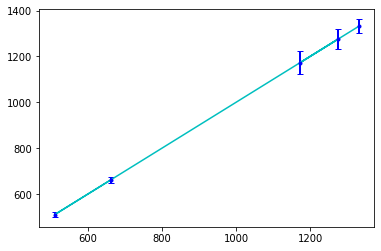

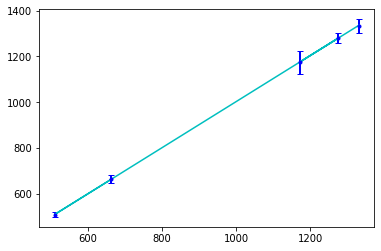

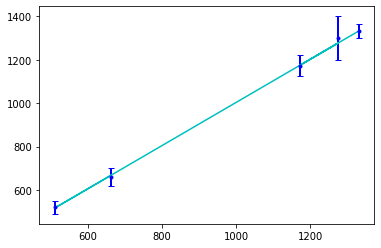

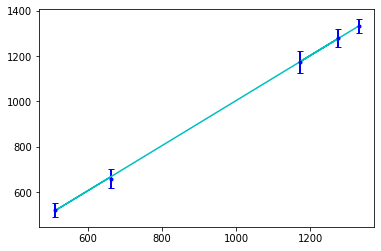

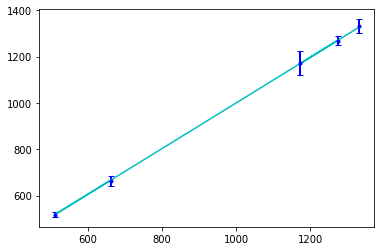

In [78]:
ch, xdata, ydata, yerr = myParser("prova.txt")

os.makedirs("/tmp/linearity_plots/", exist_ok=True)

output=open("linearità.txt", "w")
output.write("# channel\tslope\t\tsigma_slope\tintercept\tsigma_interc\n")
            
for channel in ch:  
    
    popt, pcov = curve_fit(line_func, xdata[channel], ydata[channel], sigma=yerr[channel], absolute_sigma=True)

    perr=np.sqrt(np.diag(pcov))
    
    popt=np.around(popt, 4)
    perr=np.around(perr,4)
    
    tmp=(str(popt[0]),str(perr[0]), str(popt[0]), str(perr[1]))
    output.write(str(channel)+"\t\t"+"\t\t".join(tmp)+"\n")

    plt.figure()
    
    plt.errorbar(xdata[channel], ydata[channel], yerr=yerr[channel], fmt="b.", elinewidth=2, capsize=3)
    plt.plot(xdata[channel], line_func(xdata[channel], *popt), 'c-')
    
    plt.savefig("/tmp/linearity_plots/channel" + str(channel) + ".pdf", format="pdf")

output.close()

print("Plots saved in /tmp/linearity_plots.")